<a href="https://colab.research.google.com/github/EricChan12311/DMA/blob/main/DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import urllib.request

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
# Load dataset.csv into the notebook.
data = pd.read_csv("dataset.csv")

In [4]:
data.head()

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,54:00.0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,21:31.0,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,18:00.0,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,43:00.0,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,57:17.0,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0


# Split dataset into train set and test set


In [5]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

print("Length of train_set:", len(train_set))
print("Length of test_set:", len(test_set))

Length of train_set: 82515
Length of test_set: 20629


# Visualization of the Dataset (Done By: Chan Heng Hung)

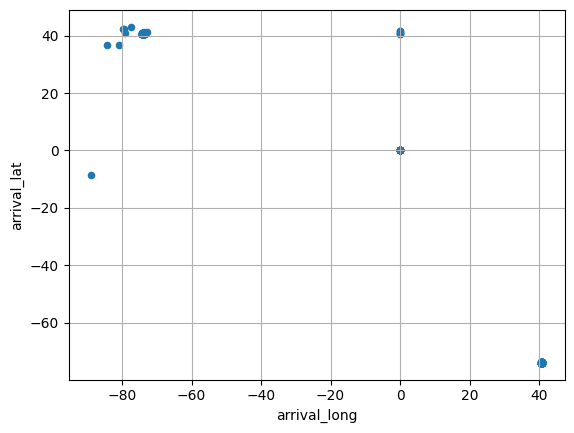

In [6]:
train_set.plot(kind="scatter", x="arrival_long", y="arrival_lat", grid=True)
plt.show()

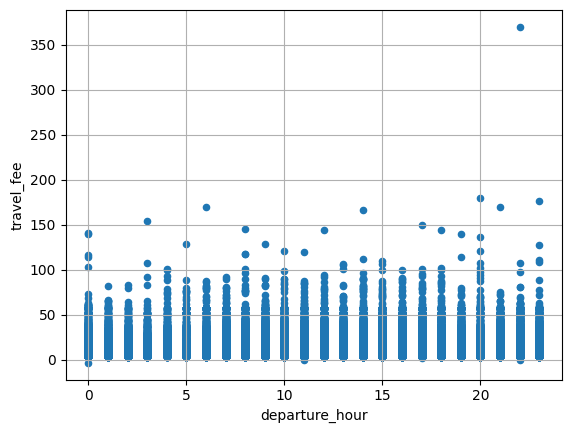

In [7]:
train_set['departure_time'] = pd.to_datetime(train_set['departure_time'])
train_set['departure_hour'] = train_set['departure_time'].dt.hour
train_set.plot(kind="scatter", x="departure_hour", y="travel_fee", grid=True)
plt.show()

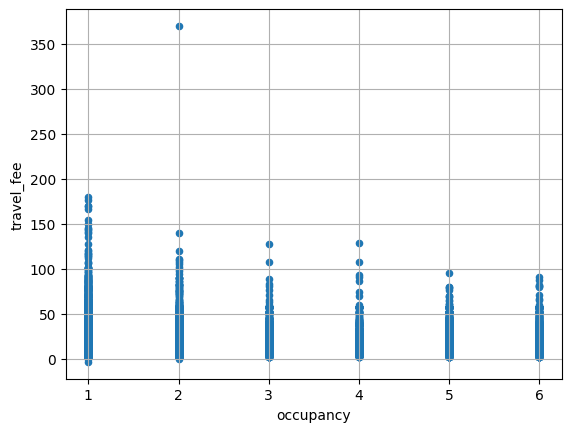

In [8]:
train_set.plot(kind="scatter", x="occupancy", y="travel_fee", grid=True)
plt.show()

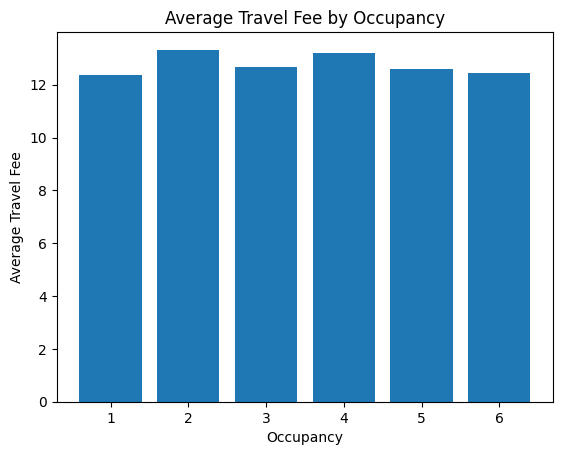

In [9]:
average_fare_by_occupancy = train_set.groupby('occupancy')['travel_fee'].mean()

plt.bar(average_fare_by_occupancy.index, average_fare_by_occupancy.values)
plt.xlabel('Occupancy')
plt.ylabel('Average Travel Fee')
plt.title('Average Travel Fee by Occupancy')
plt.xticks(average_fare_by_occupancy.index)
plt.show()

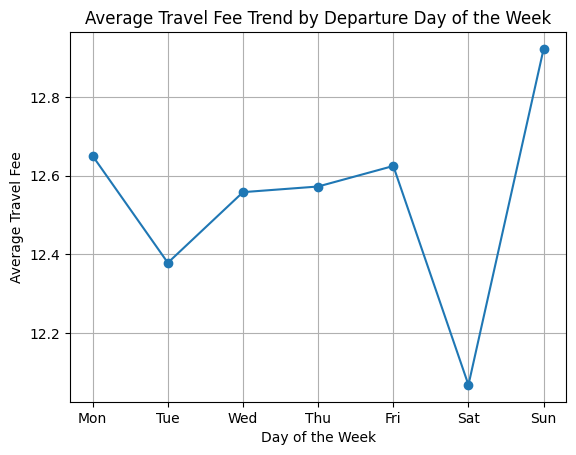

In [10]:
train_set['day_of_week'] = train_set['departure_time'].dt.dayofweek
average_fare_by_dow = train_set.groupby('day_of_week')['travel_fee'].mean()

plt.plot(average_fare_by_dow.index, average_fare_by_dow.values, marker='o')
plt.xlabel('Day of the Week')
plt.ylabel('Average Travel Fee')
plt.title('Average Travel Fee Trend by Departure Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid()
plt.show()

# Correlation Between Attributes (Done By: Eason Chuah)




In [11]:
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix["travel_fee"].sort_values(ascending=False)

travel_fee        1.000000
arrival_long      0.018275
departure_long    0.016420
occupancy         0.010637
day_of_week       0.001141
departure_lat    -0.012646
departure_hour   -0.013721
arrival_lat      -0.014442
Name: travel_fee, dtype: float64

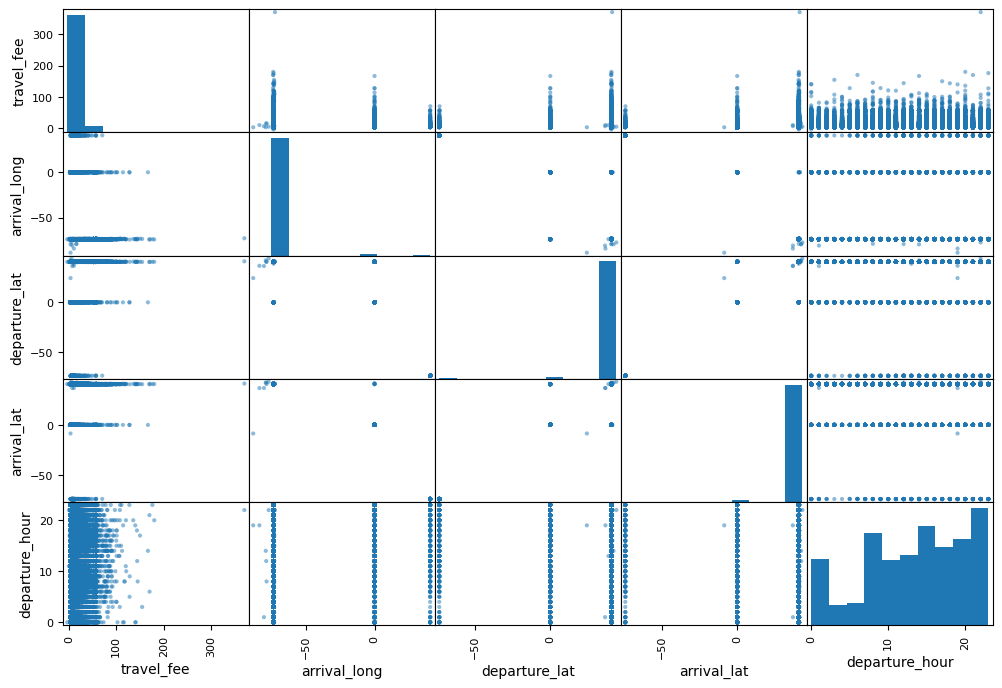

In [12]:
from pandas.plotting import scatter_matrix

attributes = ["travel_fee", "arrival_long","departure_lat","arrival_lat","departure_hour"]
scatter_matrix(train_set[attributes], figsize=(12, 8))
plt.show()

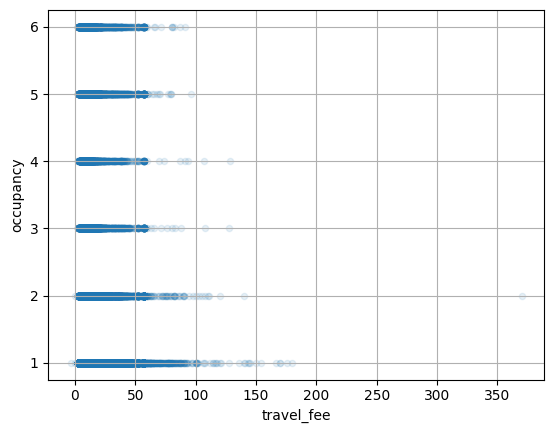

In [13]:
train_set.plot(kind="scatter", x="travel_fee", y="occupancy", alpha=0.1, grid=True)
plt.show()

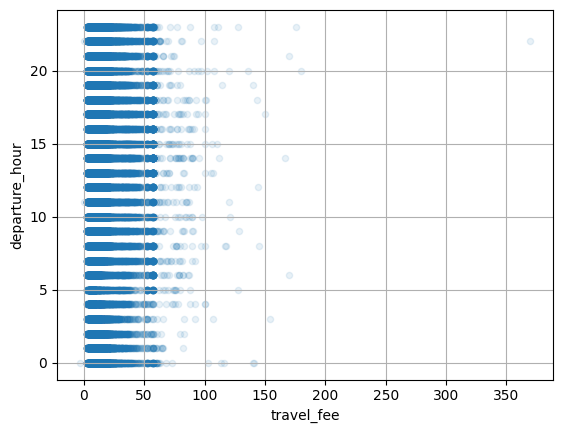

In [14]:
train_set.plot(kind="scatter", x="travel_fee", y="departure_hour", alpha=0.1, grid=True)
plt.show()

# Data Preprocessing(Done By:Foo Shao Lun)

# 1. Data Cleaning

# Handle Missing Values

In [15]:
data.dropna(inplace=True)

# Drop rows of 'travel_fee' with negative value

In [16]:
data = data[data['travel_fee'] >= 0]

# Handle Outliers using IQR

In [17]:
# Handle outliers using IQR
Q1 = data['travel_fee'].quantile(0.25)
Q3 = data['travel_fee'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['travel_fee'] >= lower_bound)&(data['travel_fee'] <= upper_bound)]

# 2. Handle Text Features

In [18]:
# Drop the 'ID' column
data.drop(columns=['ID'], inplace=True)

In [19]:
# Convert 'departure_time' to datetime format and extract components
data['departure_time'] = pd.to_datetime(data['departure_time'])
data['hour'] = data['departure_time'].dt.hour
data['day_of_week'] = data['departure_time'].dt.dayofweek
data['month'] = data['departure_time'].dt.month
data.drop(columns=['departure_time'], inplace=True)

# Determine if the travel is during the weekend
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Categorize the hour into parts of the day
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'afternoon', 'evening']
data['part_of_day'] = pd.cut(data['hour'], bins=bins, labels=labels, right=False)

# 3. Feature Engineering

In [20]:
# Calculate distance traveled using Haversine formula
# Radius of the Earth
R = 6371
lat1, lon1, lat2, lon2 = map(np.radians, [data['departure_lat'], data['departure_long'], data['arrival_lat'], data['arrival_long']])
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
data['distance_traveled'] = R * c

# 4. Feature Encoding and Scaling

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Columns to scale and encode
num_attribs = ['travel_fee', 'departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'occupancy', 'hour', 'day_of_week', 'month', 'distance_traveled']
cat_attribs = ['part_of_day']

# Numerical pipeline
num_pipeline = make_pipeline(StandardScaler())
# Categorical pipeline
cat_pipeline = make_pipeline(OneHotEncoder(drop='first'))


preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),] ,remainder='passthrough')

# Applying the preprocessing to the data
preprocessed_data = preprocessing.fit_transform(data)
preprocessed_data

array([[-0.61369815, -0.13882809,  0.12007838, ...,  0.        ,
         0.        ,  0.        ],
       [-0.93109771, -0.13961807,  0.11759801, ...,  0.        ,
         1.        ,  1.        ],
       [ 2.45449754, -0.13754645,  0.1239976 , ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [-0.2962986 , -0.13610959,  0.1229445 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.12690081, -0.13765097,  0.12380503, ...,  1.        ,
         0.        ,  1.        ],
       [-0.40209845, -0.13507575,  0.12503189, ...,  0.        ,
         0.        ,  0.        ]])

In [31]:
preprocessing.get_feature_names_out()

array(['num__travel_fee', 'num__departure_long', 'num__departure_lat',
       'num__arrival_long', 'num__arrival_lat', 'num__occupancy',
       'num__hour', 'num__day_of_week', 'num__month',
       'num__distance_traveled', 'cat__part_of_day_evening',
       'cat__part_of_day_morning', 'cat__part_of_day_night',
       'remainder__is_weekend'], dtype=object)